In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [2]:
!kaggle datasets download -d jangedoo/utkface-new

Dataset URL: https://www.kaggle.com/datasets/jangedoo/utkface-new
License(s): copyright-authors
 99% 327M/331M [00:10<00:00, 35.4MB/s]
100% 331M/331M [00:10<00:00, 33.1MB/s]


In [3]:
import zipfile
zip_ref = zipfile.ZipFile('/content/utkface-new.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [4]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm

In [5]:
import os
folder = '/content/UTKFace'

age = []
gender = []
image_paths = []

for file in os.listdir(folder):
    image_path = os.path.join(folder, file)
    temp=file.split('_')
    age_label = int(temp[0])
    gender_label = int(temp[1])

    image_paths.append(image_path)
    age.append(age_label)
    gender.append(gender_label)

In [6]:
df = pd.DataFrame({'age' : age, 'gender':gender, 'image':image_paths})

In [7]:
df.head()

,age,gender,image
0,24,0,/content/UTKFace/24_0_4_20161219192105922.jpg....
1,26,1,/content/UTKFace/26_1_0_20170117091834220.jpg....
2,34,1,/content/UTKFace/34_1_1_20170114033315738.jpg....
3,27,1,/content/UTKFace/27_1_2_20170116163736839.jpg....
4,53,1,/content/UTKFace/53_1_0_20170110122530359.jpg....


In [8]:
import tensorflow
from tensorflow import keras
from keras.models import Sequential, Model
from keras.layers import *
from keras.utils import load_img

In [9]:
def extract_feature(images):
    features = []
    for image in tqdm(images) :
        img = load_img(image, color_mode='grayscale')
        img = img.resize((128, 128))
        img = np.array(img)
        features.append(img)

    features = np.array(features)
    features = features.reshape(len(features), 128, 128, 1)
    return features

In [10]:
x = extract_feature(df['image'])

  0%|          | 0/23708 [00:00<?, ?it/s]

In [11]:
x=x/255.0

In [12]:
x.shape

(23708, 128, 128, 1)

In [13]:
y_gender = np.array(df['gender'])
y_age = np.array(df['age'])

In [14]:
input_shape = (128, 128, 1)

inputs = Input((input_shape))
conv_1 = Conv2D(32, kernel_size=(3, 3), activation='relu')(inputs)
maxp_1 = MaxPooling2D(pool_size=(2, 2))(conv_1)

conv_2 = Conv2D(64, kernel_size=(3, 3), activation='relu')(maxp_1)
maxp_2 = MaxPooling2D(pool_size=(2, 2))(conv_2)

conv_3 = Conv2D(128, kernel_size=(3, 3), activation='relu')(maxp_2)
maxp_3 = MaxPooling2D(pool_size=(2, 2))(conv_3)

conv_4 = Conv2D(256, kernel_size=(3, 3), activation='relu')(maxp_3)
maxp_4 = MaxPooling2D(pool_size=(2, 2))(conv_4)

flatten = Flatten()(maxp_4)


dense_1 = Dense(256, activation='relu')(flatten)
dense_2 = Dense(256, activation='relu')(flatten)

dropout_1 = Dropout(0.3) (dense_1)
dropout_2 = Dropout(0.3) (dense_2)

output_1 = Dense(1, activation='sigmoid', name='gender')(dropout_1)
output_2 = Dense(1, activation='relu', name='age')(dropout_2)

model = Model(inputs=[inputs], outputs=[output_1, output_2])

model.compile(loss=['binary_crossentropy', 'mae'], optimizer='Adam', metrics=['accuracy', 'mae'])


In [15]:
history = model.fit(x=x, y=[y_gender, y_age], batch_size=32, epochs=25, validation_split=0.2)

Epoch 1/25
593/593 ━━━━━━━━━━━━━━━━━━━━ 29s 34ms/step - age_mae: 16.2228 - gender_accuracy: 0.5276 - loss: 16.9217 - val_age_mae: 11.2261 - val_gender_accuracy: 0.7497 - val_loss: 11.7478
Epoch 2/25
593/593 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - age_mae: 11.0061 - gender_accuracy: 0.7551 - loss: 11.5154 - val_age_mae: 10.9146 - val_gender_accuracy: 0.7493 - val_loss: 11.4083
Epoch 3/25
593/593 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - age_mae: 9.1581 - gender_accuracy: 0.7960 - loss: 9.5968 - val_age_mae: 7.9799 - val_gender_accuracy: 0.8342 - val_loss: 8.3471
Epoch 4/25
593/593 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - age_mae: 8.2176 - gender_accuracy: 0.8340 - loss: 8.5798 - val_age_mae: 7.4087 - val_gender_accuracy: 0.8534 - val_loss: 7.7335
Epoch 5/25
593/593 ━━━━━━━━━━━━━━━━━━━━ 21s 19ms/step - age_mae: 7.4346 - gender_accuracy: 0.8547 - loss: 7.7599 - val_age_mae: 7.1241 - val_gender_accuracy: 0.8435 - val_loss: 7.4647
Epoch 6/25
593/593 ━━━━━━━━━━━━━━━━━━━━ 21s 20ms/step - age_mae: 7.1394 

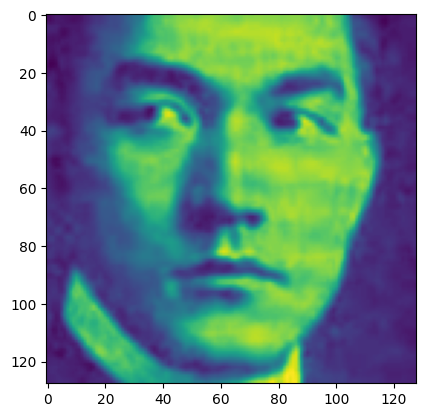

original gender :  0
original age :  32
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
predicted gender :  [0.]
predicted age :  [33.]


In [30]:
import matplotlib.pyplot as plt
image_index=453

plt.imshow(x[image_index].reshape(128, 128))
plt.show()
print('original gender : ', gender[image_index])
print('original age : ', age[image_index])

pred = model.predict(x[image_index].reshape(1, 128, 128, 1))
print('predicted gender : ', np.round(pred[0][0]))
print('predicted age : ', np.round(pred[1][0]))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
predicted gender :  [0.]
predicted age :  [69.]


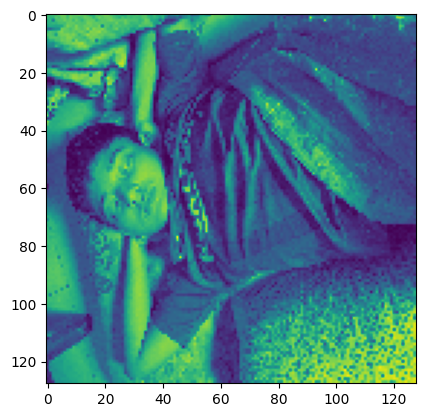

In [33]:
from keras.utils import load_img, img_to_array
import numpy as np

def preprocess_image(image_path):
    img = load_img(image_path, color_mode='grayscale', target_size=(128, 128))
    img_array = img_to_array(img)
    img_array = img_array / 255.0
    img_array = np.expand_dims(img_array, axis=0)  # Reshape to (1, 128, 128, 1)
    return img_array

# Preprocess the image
image_path = '/content/fardin.jpeg'  # Replace with your image path
preprocessed_image = preprocess_image(image_path)

pred = model.predict(preprocessed_image)
# Predict using the model

plt.imshow(preprocessed_image.reshape(128, 128))
print('predicted gender : ', np.round(pred[0][0]))
print('predicted age : ', np.round(pred[1][0]))

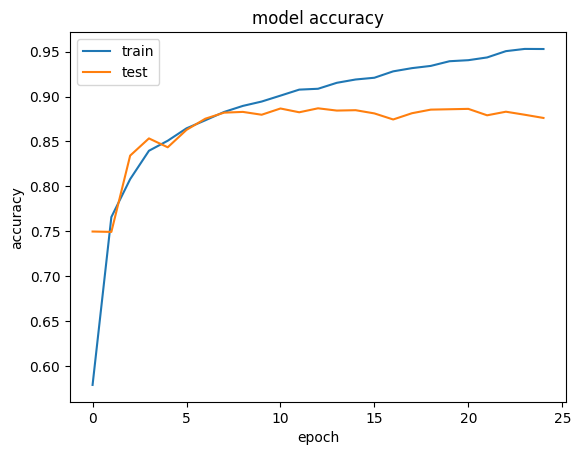

In [34]:
plt.plot(history.history['gender_accuracy'])
plt.plot(history.history['val_gender_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()